# Blood Cell Data

This project uses a dataset containing 17,092 images of normal blood cells from healthy individuals with no infection or disease.  It includes eight types of cells: neutrophils, eosinophils, basophils, lymphocytes, monocytes, immature granulocytes, erythroblasts, and platelets. The labels were annotated bt a licensed pathologist.

The team will build machine learning models that make predictions wether a blood cell is a particular type of cell.

[Link to colab](https://colab.research.google.com/drive/1PsfJpbSpvKXoyf-guUt_6pjyC9GhM7_E?usp=sharing)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import zipfile
import requests
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
import cv2
from sklearn import cluster, decomposition
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

**Loading the Data:**

Images from Kaggle are unzipped and uploaded to Google Drive. Connect to  Google Drive to access.

In [2]:
# Load Data
# URL of the zip file
url = "https://www.renaqd.com/ADS/bloodcells_dataset.zip"
bloodcells_dataset = "bloodcells_dataset"
zip_file_path = "bloodcells_dataset.zip"

# Check if the bloodcells_dataset folder exists
if not os.path.exists(bloodcells_dataset):
    # Download the zip file
    response = requests.get(url)
    with open(zip_file_path, 'wb') as file:
        file.write(response.content)

    # Ensure the bloodcells_dataset folder exists
    os.makedirs(bloodcells_dataset, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(bloodcells_dataset)

    print(f"Extracted files to {bloodcells_dataset}")
else:
    print(f"The folder '{bloodcells_dataset}' already exists")

The folder 'bloodcells_dataset' already exists


In [3]:
path = "bloodcells_dataset"
print("\nRetrieving blood cell images from:")
print(path)

# Glob to search recursively within path
folders = glob.glob(os.path.join(path, '**'), recursive=True) #  finds all the pathnames matching a specified pattern
i = 0
cell_col = []

for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        i = i +1
        cell_col.append(f)

img_count = str(i)
print("\nBlood bell images found: " + str(i))


Retrieving blood cell images from:
bloodcells_dataset

Blood bell images found: 17092


In [4]:
# Save matrix
cell_col = np.array(cell_col)
np.save('cell_col.npy', cell_col)

# cell_col = np.load('cell_col.npy')

In [5]:
# Dictionary to store one image path per folder
folder_image_dict = {}

# Loop through each folder and subfolder
for folder in folders:
    # Check if it is a directory
    if os.path.isdir(folder):

        # Find all .jpg files in the current folder
        jpg_files = glob.glob(os.path.join(folder, '*.jpg'))
        print(f"{len(jpg_files)} image files in {folder}")

        if jpg_files:
            # Store the first image found in the current folder
            folder_image_dict[folder] = jpg_files[0]

0 image files in bloodcells_dataset/
0 image files in bloodcells_dataset/bloodcells_dataset
2348 image files in bloodcells_dataset/bloodcells_dataset/platelet
1420 image files in bloodcells_dataset/bloodcells_dataset/monocyte
1551 image files in bloodcells_dataset/bloodcells_dataset/erythroblast
1214 image files in bloodcells_dataset/bloodcells_dataset/lymphocyte
3117 image files in bloodcells_dataset/bloodcells_dataset/eosinophil
1218 image files in bloodcells_dataset/bloodcells_dataset/basophil
2895 image files in bloodcells_dataset/bloodcells_dataset/ig
3329 image files in bloodcells_dataset/bloodcells_dataset/neutrophil


# EDA and Pre-Processing

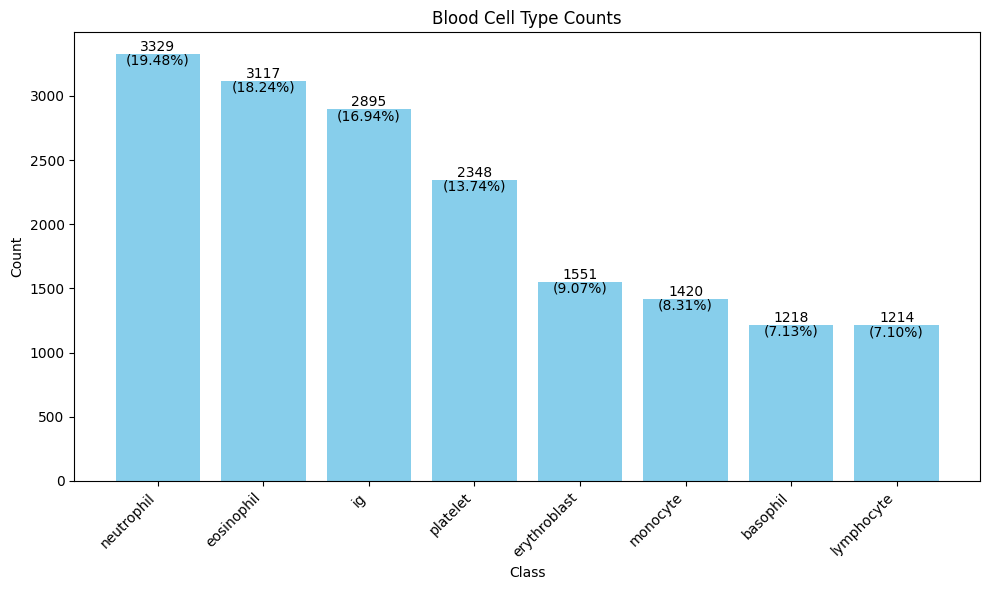

In [6]:
# Classes
classes = ["platelet", "monocyte", "erythroblast", "lymphocyte", "eosinophil",
           "basophil", "ig", "neutrophil"]
frequencies = [2348, 1420, 1551, 1214, 3117, 1218, 2895, 3329]

# Sort the classes by count
sorted_data = sorted(zip(classes, frequencies), key=lambda x: x[1], reverse=True)
sorted_classes, sorted_frequencies = zip(*sorted_data)

# Sum of frequencies for ratio
total_count = sum(sorted_frequencies)

# Calculate the ratio of each class
class_ratios = [freq / total_count for freq in sorted_frequencies]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, sorted_frequencies, color='skyblue', label="Count")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Blood Cell Type Counts")
plt.xticks(rotation=45, ha='right')

# Count values above the bars
for i, freq in enumerate(sorted_frequencies):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

# Ratio values on top
for i, ratio in enumerate(class_ratios):
    plt.text(i, sorted_frequencies[i], f"({ratio:.2%})", ha='center', va='top', color='black')

plt.tight_layout()
plt.show()

In [7]:
def plot_images_from_folders(folder_image_dict, convert_to_rgb=False, convert_to_gray=False):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    axes = axes.flatten()

    for i, (folder, img_path) in enumerate(folder_image_dict.items()):
        if i >= 8:  # Plot 8 images
            break

        img = cv2.imread(img_path)  # Load the image from the specified file

        if convert_to_gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale if True
            axes[i].imshow(img, cmap='gray')  # Display the image in grayscale
        elif convert_to_rgb:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB if True
            axes[i].imshow(img)  # Display the image in RGB
        else:
            axes[i].imshow(img)  # Display the original image

        axes[i].set_title(os.path.basename(folder))  # Set the title as the folder name
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Displaying 1 image from each type of blood cell.

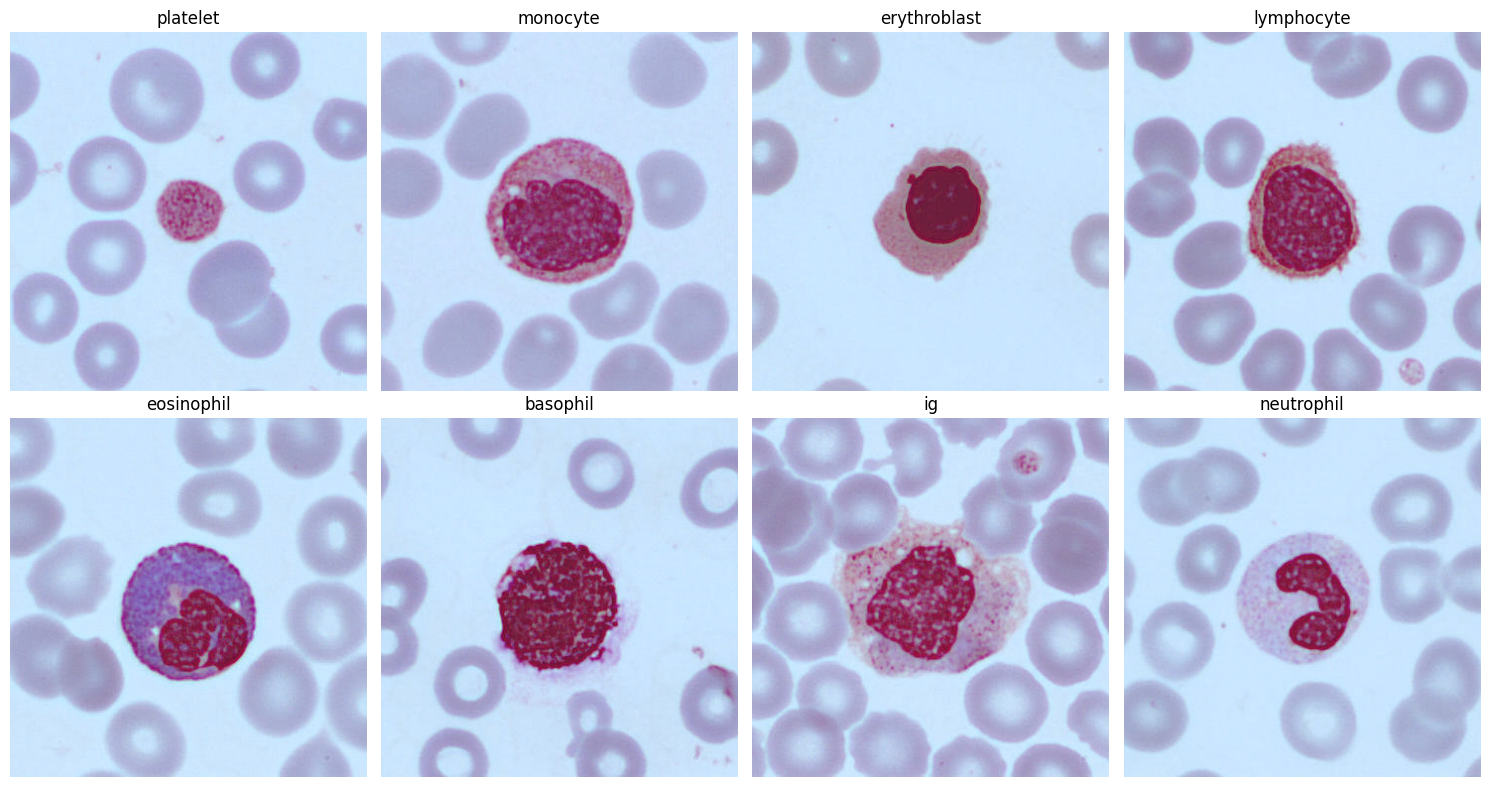

In [8]:
plot_images_from_folders(folder_image_dict)

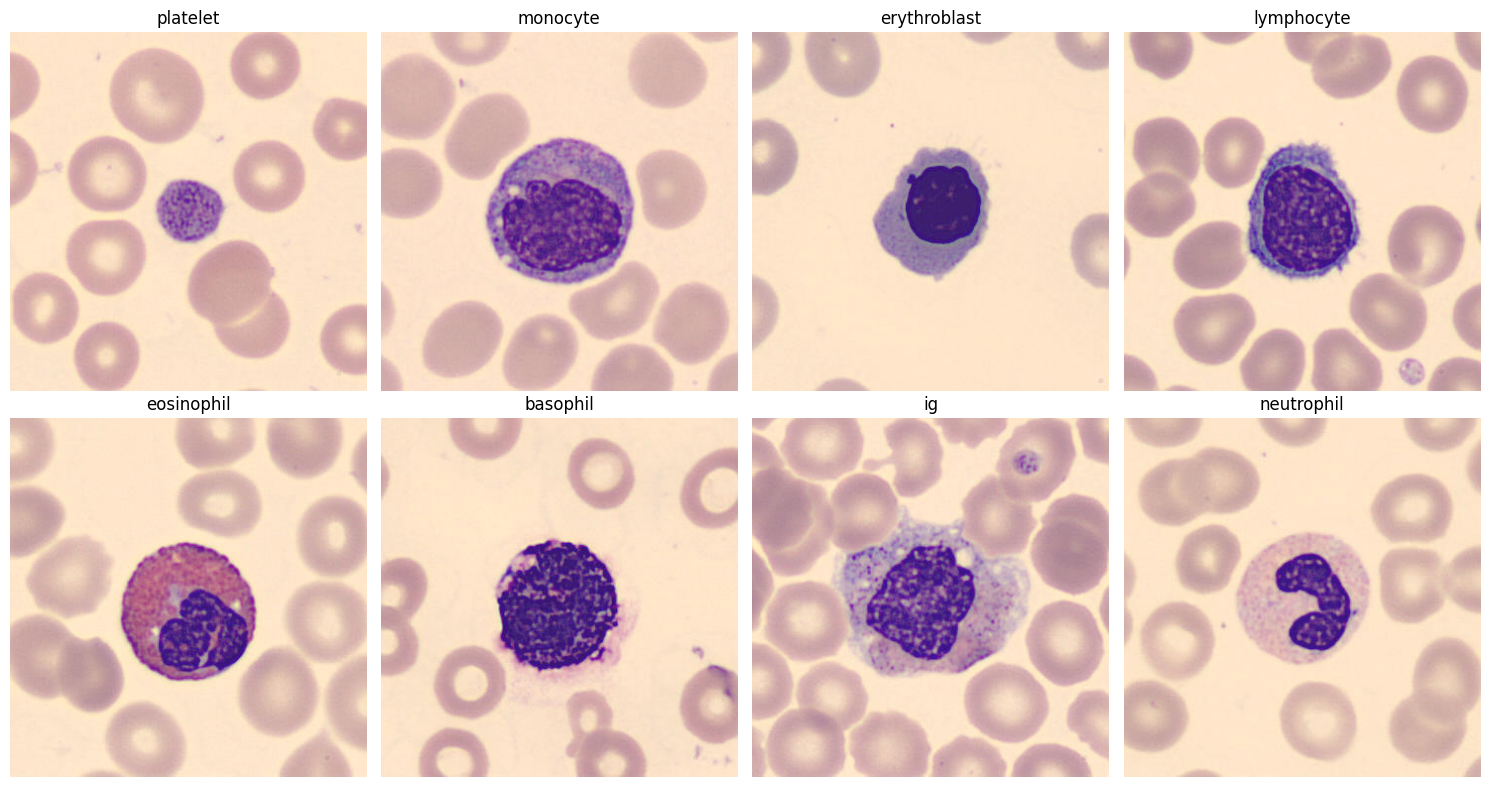

In [9]:
plot_images_from_folders(folder_image_dict, convert_to_rgb=True)

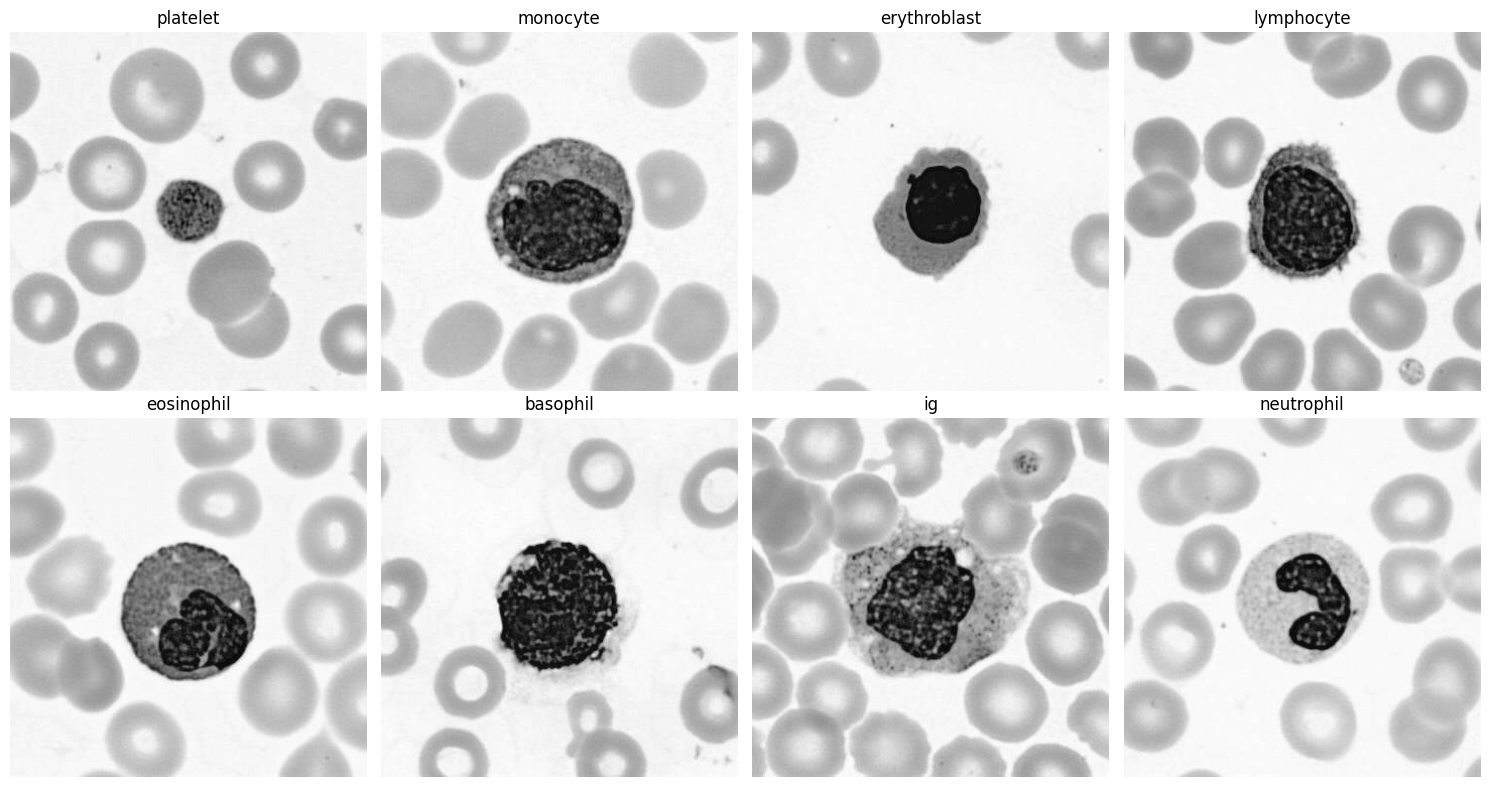

In [10]:
plot_images_from_folders(folder_image_dict, convert_to_gray=True)

Ensure all images are uniform sized and centered.

In [18]:
# Define the target shape (height, width)
target_shape = (64, 64)

cell_col_num = []

for i in range(0, 17092):
    # Read and convert the image to grayscale
    image = imread(cell_col[i])
    grayscale_image = rgb2gray(image)
    # Resize the grayscale image to the target shape
    resized_image = resize(grayscale_image, target_shape, anti_aliasing=True)
    # Append the resized image to the list
    cell_col_num.append(resized_image)

# Convert the list to a NumPy array
cell_col_num = np.array(cell_col_num)

print(cell_col_num.shape)

(17092, 64, 64)


In [27]:
# Save matrix
np.save('cell_col_num.npy', cell_col_num)

# cell_col_num = np.load('cell_col_num.npy')

In [19]:
cell_col_num = np.array(cell_col_num)
cell_resh = cell_col_num.reshape(cell_col_num.shape[0], cell_col_num.shape[1] * cell_col_num.shape[1])

cell_centered = cell_resh - cell_resh.mean(axis=0)
cell_centered -= cell_centered.mean(axis=1).reshape(cell_col_num.shape[0], -1)

In [12]:
# Use PCA and cross-validation

cv_scores = []
for i in range(0,16):
    pca = PCA(svd_solver='full', n_components=i)
    print('n_components = %d' % i)
    cv_scores.append(cross_val_score(pca, cell_centered, n_jobs=2).mean())

n_components = 0
n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15


In [13]:
# Save list
np.save('saved_cv_scores.npy', cv_scores)

In [6]:
# Load list
cv_scores = np.load('saved_cv_scores.npy')

In [20]:
pca = PCA(svd_solver='full', n_components=16)
pca.fit(cell_centered)

PCA(n_components=16, svd_solver='full')

In [21]:
rec_error = pd.DataFrame({
    'n_components': np.arange(0,16),
    'reconst error': cv_scores,
    'explained var ratio': pca.explained_variance_ratio_})

rec_error

,n_components,reconst error,explained var ratio
0,0,2684.433824,0.125423
1,1,2896.362021,0.047201
2,2,3043.457170,0.024395
3,3,3108.181215,0.019752
4,4,3155.644748,0.018143
5,5,3199.882514,0.017110
6,6,3290.547975,0.015542
7,7,3329.771266,0.013412
8,8,3364.128173,0.013166
9,9,3398.538018,0.012546


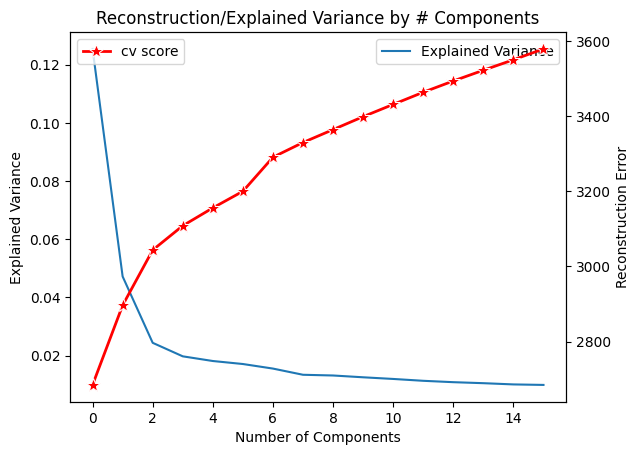

In [22]:
fig, ax = plt.subplots()
sns.lineplot(x=rec_error['n_components'], y=rec_error['explained var ratio'],
             ax=ax, label='Explained Variance')

ax2 = ax.twinx()
sns.lineplot(x=rec_error['n_components'], y=rec_error['reconst error'],
             legend=True, marker= '*', markersize=10, color='red', linewidth=2,
             ax=ax2, label='cv score')
plt.title('Reconstruction/Explained Variance by # Components')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance')
ax2.set_ylabel('Reconstruction Error')
plt.show()

# Modeling Methods, Validation, and Performance Metrics

Deep Learning

In [26]:
# Split Data
cells_df = tf.keras.preprocessing.image_dataset_from_directory("bloodcells_dataset/bloodcells_dataset")
cells_train = tf.keras.preprocessing.image_dataset_from_directory("bloodcells_dataset/bloodcells_dataset",
                                                               validation_split=0.2,
                                                               subset = "training",
                                                               seed=504)
cells_validation = tf.keras.preprocessing.image_dataset_from_directory("bloodcells_dataset/bloodcells_dataset",
                                                                       validation_split=0.2,
                                                                       subset="validation",
                                                                       seed=504)

Found 17092 files belonging to 8 classes.
Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


In [30]:
# Define batch size and print image labels
batch_size = 64

cells_data = cells_df
class_names = cells_df.class_names
print(class_names)

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


In [32]:
# Standardize daata
size = (360, 360)
df_train = cells_train.map(lambda image, label: (tf.image.resize(image, size), label))
df_val = cells_validation.map(lambda image, label: (tf.image.resize(image, size), label))

# Modeling Results and Findings